# Предсказание пропусков в последовательности генов

* **Компания:** Интеллектуальные решения
* **Автор нотбука:** Петросян Акоб
* **Номер:** +79309878934
* **Адрес:** МФТИ, г. Долгопрудный, Московская область
* **Обратная связь:** akob.petrosyan@phystech.edu, [vk.com/jacpetro](vk.com/jacpetro), [https://t.me/jacpetro](https://t.me/jacpetro).

![](https://media.hswstatic.com/eyJidWNrZXQiOiJjb250ZW50Lmhzd3N0YXRpYy5jb20iLCJrZXkiOiJnaWZcL2NlbGx1bGFyLW1pY3Jvc2NvcGljLWRuYS5qcGciLCJlZGl0cyI6eyJyZXNpemUiOnsid2lkdGgiOjgyOH19fQ==)

## Задача:
Есть последовательность ДНК. Как известно, она состоит из букв A, C, T, G. В биоинформатике есть такая задача - предсказывать недостающие данные (пропуски) в последовательности генов. Например, есть пропуск в последовательности. Знаем, что есть 5-30 известных символов слева, 5-30 известных символов - справа от этого пропуска. Вам предоставляется файл
расширения fasta.<br>
Ссылка на файл:<br>
[https://yadi.sk/d/CgxttuimPIaZKg](https://yadi.sk/d/CgxttuimPIaZKg)<br>
Ваша задача - написать на `python` код, который позволяет подготовить данные модели на обучение, а также саму модель с необходимыми метриками. <br>

*ПРИМЕР.*<br>
CGTAACGTGAACATCTTTAAATTCATCATTCCTAATGTTGTAAAATACAGCCCGA<br>
CGTAACGTGAACATCTTTAAATTC_ TCATTCCTAATGTTGTAAAATACAGCCCGA<br>
Надо предсказать букву A.<br>
Как будут входные данные подаваться на вход - на ваше усмотрение.<br>
<br>
**Замечание.**<br>
В некоторых строках вначале стоят буквы N - от них можно избавиться.<br>
Строки, в которых содержаться символы, кроме TCGA можно не использовать.<br>

## Решение

Мне кажется, что в любом случае существуют определенные способы решения подобных проблем в биоинформатике, но так как я не являюсь экспертом в этой области, я решил использовать bidirectional LSTM. 
Почему именно этот RNN? Да, потому что у него довольно большая долговременная память. Плюс это то, что пришло мне в голову в первую очередь, поэтому почему бы и нет.) С другой стороны, интересно посмотреть, как поведёт себя LSTM в подобных задачах.

Ну что, приступим!

### Необходимые модули

In [11]:
# To parse fasta file

!pip install biopython

In [12]:
import os
import zipfile
import torch
import torchsummary
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm, tqdm_notebook
from Bio import SeqIO

In [13]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
DEVICE = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is not available.  Training on CPU ...


## Visualization

Но перед этим давайте настроим конфиг matplotlib для красивых графиков.

![](https://miro.medium.com/max/1200/1*EgzT1xvIzpv-z4oZH2eWBw.jpeg)

In [14]:
# To make beautiful graphics
plt.style.use("seaborn-dark")

# Colot sheet
COLORS = [
    '#FE53BB',  # pink
    '#08F7FE',  # teal/cyan
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]

# Making beautifull dark style
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey

N_SHADES = 10
DIFF_LINEWIDTH = 1.05
ALPHA_VALUE = 0.3 / N_SHADES

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

In [77]:
def plot_losses(losses: tuple, title: str=None, colors: list=COLORS) -> None:
    """
    Plot graphics of train and validation losses.
    
    :param losses: a tuple of train and validation losses data
    :param title: a title of graphics
    :param colors: list of required colors
    
    :return: None.
    """
    fig = plt.figure(figsize=(20, 10))
    plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background

    plt.plot(losses[0], marker='o', color=colors[0], label="Train")
    plt.plot(losses[1], marker='o', color=colors[1], label="Validation")
    
    # Redraw the data with low alpha and slighty increased linewidth:x
    for n in range(1, N_SHADES+1):
        plt.plot(losses[0], marker='o', linewidth=2+(DIFF_LINEWIDTH*n), alpha=ALPHA_VALUE, color=colors[0])
        plt.plot(losses[1], marker='o', linewidth=2+(DIFF_LINEWIDTH*n), alpha=ALPHA_VALUE, color=colors[1])
    
    if title is not None:
        plt.title(title, fontsize=BIGGER_SIZE)
    
    # Color the areas below the lines:
    plt.fill_between(x=range(len(losses[0])), y1=losses[0], color=colors[0], alpha=0.1)
    plt.fill_between(x=range(len(losses[1])), y1=losses[1], color=colors[1], alpha=0.1)
    
    plt.ylabel('Loss', fontsize=MEDIUM_SIZE)
    plt.xlabel('Batches during all epochs #', fontsize=MEDIUM_SIZE)
    plt.legend(fontsize=SMALL_SIZE)
    plt.show()

## Let's GO!

In [16]:
# Extracting the Fasta file
CURR_PATH = os.getcwd()
print(CURR_PATH)

with zipfile.ZipFile("mart_export.zip", 'r') as zip_ref:
    zip_ref.extractall(CURR_PATH)

C:\Users\hakob\Desktop\KissMe\MIPT\My researches and studies\TestingScripts\Интелектуальные решения - задача


In [17]:
# " " token used for padding
tokens = [" ", "A", "C", "T", "G"]
ids = [0, 1, 2, 3, 4]

id_to_token = {idx : token for idx, token in zip(ids, tokens)}
token_to_id = {token : idx for idx, token in zip(ids, tokens)}

In [18]:
def check_seq(sequence: list, correct: list) -> bool:
    """
    Check is there not allowed tokens in sequence
    
    ։param sequence: a seqeunce that need to be checked
    ։param correct: a list of correct tokens
    
    :return: bool. True if sequnce is correct, False else.
    """
    for elem in set(sequence):
        if elem in correct:
            pass
        else:
            return False
    return True


def fasta_to_list(infile: str, correct_tokens: list) -> list:
    """
    Parse fasta file to list of lists.
    
    ։param infile: a path to txt(fasta) file
    ։param correct: a list of correct tokens
    
    :return: list. List of list-sequences.
    """
    records = SeqIO.parse(infile, 'fasta')
    seq_list = []
    for record in records:
        if record[0] == 'N':
            record = record[1:]
        if check_seq(record.seq, correct_tokens):
            seq = list(record.seq)
            seq_list.append(seq)
    return seq_list

Sequence max len:  107976
Number of DNA sequences:  106574
Wall time: 51.4 s


(0.0, 15000.0)

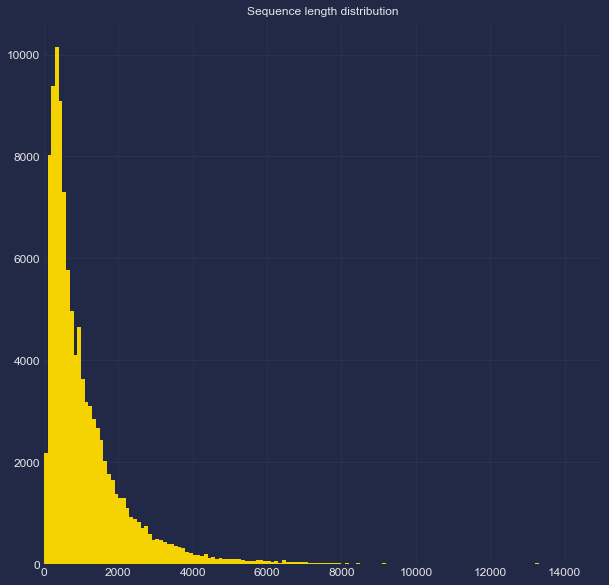

In [19]:
%%time
genome = fasta_to_list("mart_export.txt", tokens)

max_len = max(map(len, genome))
print("Sequence max len: ", max_len)
print("Number of DNA sequences: ", len(genome))

plt.figure(figsize=(10, 10))
plt.grid(color='#2A3459')
plt.title('Sequence length distribution')
plt.hist(list(map(len, genome)), bins = range(0, len(genome), 100), color=COLORS[2]);
plt.xlim(0, 15000)

In [20]:
# So let's remove sequences longer then 15000

genome = list(filter(lambda sentence : len(sentence) < 15000, genome))

len(genome)

106464

In [21]:
class DNA_Data(Dataset):
    def __init__(self, data, dtype=None, batch_first=True, infile_path=None, max_len=None, one_hot_enc=False):
        super().__init__()
        self.tokens = [" ", "A", "C", "T", "G"]
        self.ids = [0, 1, 2, 3, 4] 
        self.id_to_token = {idx : token for idx, token in zip(self.ids, self.tokens)}
        self.token_to_id = {token : idx for idx, token in zip(self.ids, self.tokens)}
        self.pad = self.token_to_id[" "]
        self.dtype = dtype
        self.one_hot = one_hot_enc
        self.batch_first = batch_first
        self.max_len = max_len or max(map(len, data))
        
        if infile_path is None:
            self.data = data
            self.infile_path = None
        else:
            self.infile_path = infile_path
    
    
    def __repr__(self):
        return "DNA_Data object"
    
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        if self.infile_path is None:
            result = self.__prepare_data(self.data[idx])
            input_ = result[:-1]
            target = result[1:]
            return input_, target
        else:
            with open(self.infile_path) as fp:
                for i, line in enumerate(fp):
                    if i == idx:
                        line = line.strip()
                        line_list = line.split(", ")
                        result = self.prepare_data(line_list)
                        return result[:-1], result[1:] # input, target
    
    
    def __to_tensor(self, genome: list):
        """Casts a list of ints into rnn-digestable tensor
        
        :param self: DNA_Data object
        :param genome: list of sequences
        
        :return: torch.Tensor.
        """        
        genome_tensor = torch.FloatTensor([self.token_to_id[c] for c in genome])
        
        if not self.batch_first: # convert [batch, time] into [time, batch]
            genome_tensor = torch.transpose(genome_tensor, 0, 1)
    
        return genome_tensor
    
    
    def __prepare_data(self, genome: list):
        genome = self.__to_tensor(genome)
        if self.one_hot:
            genome = F.one_hot(genome.to(torch.int64))
        return genome.type(self.dtype)

In [22]:
# Because by default DataLoader doesn't work with samples of differrent size
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

In [23]:
# Since we have a lot of data, let's just divide it into three parts(train, validation, test)
len_genome = len(genome)
genome_train = genome[:int(0.6*len_genome)]
genome_val = genome[int(0.6*len_genome):int(0.8*len_genome)]
genome_test = genome[int(0.8*len_genome):]

dna_train = DNA_Data(genome_train, dtype=torch.float16)
dna_val = DNA_Data(genome_val, dtype=torch.float16)
dna_test = DNA_Data(genome_test, dtype=torch.float16)

input_, target = dna_train[0]
print(f"Input shape: {input_.shape}, target.shape: {target.shape}")
print(f"Input type: {input_.type()}")
print(f"Example of input_: {input_}, targer: {target}")

Input shape: torch.Size([482]), target.shape: torch.Size([482])
Input type: torch.HalfTensor
Example of input_: tensor([1., 3., 4., 4., 1., 4., 1., 3., 2., 2., 2., 3., 4., 3., 4., 2., 2., 3.,
        4., 3., 4., 2., 1., 4., 2., 2., 4., 3., 2., 3., 3., 4., 4., 2., 3., 4.,
        2., 4., 2., 2., 4., 2., 4., 2., 2., 3., 2., 4., 4., 2., 2., 2., 2., 4.,
        3., 3., 4., 2., 2., 2., 4., 4., 1., 2., 3., 3., 3., 2., 4., 4., 2., 4.,
        2., 2., 2., 4., 4., 1., 2., 4., 2., 2., 3., 2., 3., 3., 3., 4., 1., 2.,
        2., 1., 4., 2., 4., 2., 3., 3., 2., 4., 4., 2., 4., 1., 4., 4., 4., 4.,
        2., 3., 4., 2., 3., 4., 4., 1., 4., 4., 2., 2., 4., 1., 4., 2., 3., 4.,
        4., 2., 3., 4., 2., 4., 2., 3., 2., 3., 4., 2., 2., 2., 2., 1., 2., 2.,
        1., 2., 4., 2., 3., 2., 4., 2., 2., 2., 2., 2., 3., 1., 2., 3., 1., 2.,
        2., 3., 4., 2., 4., 2., 4., 2., 1., 2., 2., 2., 1., 4., 2., 4., 3., 4.,
        4., 2., 4., 2., 3., 4., 2., 2., 2., 4., 3., 2., 4., 2., 2., 2., 1., 4.,
        

### Building model

In [24]:
import torch, torch.nn as nn
import torch.nn.functional as F

class LSTMRNN(nn.Module):
    def __init__(self, input_size=len(tokens), embedding_size=3,
                 output_size=len(tokens), hidden_dim=3, n_layers=1, with_padd=False):
        super(LSTMRNN, self).__init__()
        
        self.with_pad = with_padd
        self.hidden_dim = hidden_dim # Number of RNN units
        self.n_layers = n_layers
        if self.with_pad:
            self.need_init_hidden = True
            self.last_hidden = None # To pass then LSTM last hidden state 
        
        self.emb = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_size)
    
    
    @staticmethod
    def simple_elementwise_apply(fn, packed_sequence):
        """applies a pointwise function fn to each element in packed_sequence"""
        return torch.nn.utils.rnn.PackedSequence(fn(packed_sequence.data.long()), packed_sequence.batch_sizes)
    
    
    def init_hidden(self, batch_size):
        # Let's try Xavier initialization
        h0 = torch.zeros(2*self.n_layers, batch_size, self.hidden_dim, requires_grad=True, dtype=torch.float)
        c0 = torch.zeros(2*self.n_layers, batch_size, self.hidden_dim, requires_grad=True, dtype=torch.float)
        return (torch.nn.init.normal_(h0), torch.nn.init.normal_(c0))
    
    
    def forward(self, x):       
        # With padding 
        if self.with_pad:
            batch_size = len(x)
            if self.need_init_hidden:
                hidden = self.init_hidden(batch_size)
                self.need_init_hidden = False
            else:
                # We do detach, because we don't whant the backpropagation go even back through older batches
                h0, c0 = self.last_hidden
                hidden = (h0.detach(), c0.detach())
            
            lengths = [sequence.size(0) for sequence in x]   # get the length of each sequence in the batch
            x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True)  # padd all sequences
            batch_size, s = x_padded.shape
        
            # Pack padded sequece
            x_padded = nn.utils.rnn.pack_padded_sequence(x_padded, lengths=lengths, batch_first=True, enforce_sorted=False)
            x_padded.to(DEVICE)
            
            # Embedding
            x_padded = LSTMRNN.simple_elementwise_apply(self.emb, x_padded)
            
            # LSTM
            out, hidden = self.lstm(x_padded.to(torch.float), hidden)
            
            # Unpacking
            out, lens_unpacked = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
            out = out.view(batch_size, s, 2*self.hidden_dim)
            out = out.contiguous()
            
            # FC
            out = self.fc(out)
            out = F.log_softmax(out, dim=-1)
            
            self.last_hidden = hidden
            return out, hidden
        else:
            # Without padding
            hidden = None
            outputs = []
            for i, sequence in enumerate(x):
                sequence.to(DEVICE)
                batch_size = len(sequence)
                hidden = self.init_hidden(batch_size)              
                sequence = self.emb(sequence.unsqueeze(1).long())
                out, hidden = self.lstm(sequence, hidden)
                out = out.squeeze()
                out = out.contiguous()
                out = self.fc(out)
                out = F.log_softmax(out, dim=-1)
                outputs.append(out)
            return outputs, hidden

In [25]:
dna_model = LSTMRNN()
dna_model = dna_model.to(DEVICE)

N_EPOCHS = 3
LR = 0.001
BATCH_SIZE = 512

In [26]:
def fit_epoch(model, train_loader, optimizer, history: list, metrics: dict):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output, _ = model(inputs) # _ ~> hidden_state (we don't need to save)
        
        if not model.with_pad:
            output = nn.utils.rnn.pad_sequence(output, batch_first=True)
        targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)        
        
        output = output.to(DEVICE)
        targets = targets.to(DEVICE)
           
        running_loss = F.nll_loss(output.view(-1, 5), targets.view(-1).long())
        running_loss.backward()
        optimizer.step()
        
        history.append(running_loss.data.numpy())
        metrics["accuracy"].append(
            accuracy_score(torch.argmax(output.view(-1, 5), dim=1).numpy(), targets.view(-1).long().numpy())
        )
        metrics["f1_score"].append(
            f1_score(torch.argmax(output.view(-1, 5), dim=1).numpy(), targets.view(-1).long().numpy(), average="micro")
        )
        
    return running_loss

In [27]:
def eval_epoch(model, val_loader, history: list, metrics: dict, valid_loss_min):
    model.eval()
    running_loss = 0.0

    for inputs, targets in val_loader:        
        with torch.set_grad_enabled(False):
            output, _ = model(inputs) # _ ~> hidden_state (we don't need)
            
            if not model.with_pad:
                output = nn.utils.rnn.pad_sequence(output, batch_first=True)
            targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)
            
            output = output.to(DEVICE)
            targets = targets.to(DEVICE)
            
            running_loss = F.nll_loss(output.view(-1, 5), targets.view(-1).long())
            
            if running_loss.numpy() <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                running_loss.numpy()))
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = running_loss.numpy()
        
            history.append(running_loss.data.numpy())
            metrics["accuracy"].append(
                accuracy_score(torch.argmax(output.view(-1, 5), dim=1).numpy(), targets.view(-1).long().numpy())
            )
            metrics["f1_score"].append(
                f1_score(torch.argmax(output.view(-1, 5), dim=1).numpy(), targets.view(-1).long().numpy(), average="micro")
            )
            
    return running_loss

In [28]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=my_collate, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=my_collate, shuffle=False)

    train_history = []
    val_history = []
    train_metrics = {"accuracy" : [], "f1_score" : []}
    val_metrics = {"accuracy" : [], "f1_score" : []}
    
    valid_loss_min = np.Inf
    
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=LR)

        for epoch in range(epochs):
            running_train_loss = fit_epoch(model, train_loader, opt, train_history, train_metrics)
            
            running_val_loss = eval_epoch(model, val_loader, val_history, val_metrics, valid_loss_min)            
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=running_train_loss,
                                           v_loss=running_val_loss, t_acc=train_metrics["accuracy"][-1],
                                           v_acc=val_metrics["accuracy"][-1]))
                       
    return train_history, val_history, train_metrics, val_metrics

# Now...
![ALt Text](https://media.tenor.com/images/2471505153e8225ff6940afc65fba1f8/tenor.gif)

In [29]:
%%time
train_history, val_history, train_metrics, val_metrics = train(
    dna_train, dna_val, model=dna_model, epochs=N_EPOCHS, batch_size=BATCH_SIZE)

# Saving model
torch.save(dna_model.state_dict(), CURR_PATH)

epoch:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.099035).  Saving model ...
Validation loss decreased (0.099035 --> 0.093222).  Saving model ...
Validation loss decreased (0.093222 --> 0.070871).  Saving model ...


epoch:  33%|████████████████████████▎                                                | 1/3 [43:30<1:27:01, 2610.90s/it]


Epoch 001 train_loss: 0.0837     val_loss 0.1132 train_acc 0.9583 val_acc 0.9430
Validation loss decreased (inf --> 0.094608).  Saving model ...
Validation loss decreased (0.094608 --> 0.089081).  Saving model ...
Validation loss decreased (0.089081 --> 0.067747).  Saving model ...


epoch:  67%|████████████████████████████████████████████████▋                        | 2/3 [1:54:23<59:36, 3576.62s/it]


Epoch 002 train_loss: 0.0800     val_loss 0.1083 train_acc 0.9593 val_acc 0.9448
Validation loss decreased (inf --> 0.093088).  Saving model ...
Validation loss decreased (0.093088 --> 0.087642).  Saving model ...
Validation loss decreased (0.087642 --> 0.066650).  Saving model ...


epoch: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [2:39:22<00:00, 3187.49s/it]


Epoch 003 train_loss: 0.0787     val_loss 0.1066 train_acc 0.9598 val_acc 0.9457


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\hakob\\Desktop\\KissMe\\MIPT\\My researches and studies\\TestingScripts\\Интелектуальные решения - задача'

## Let's have a look at graphic of losses

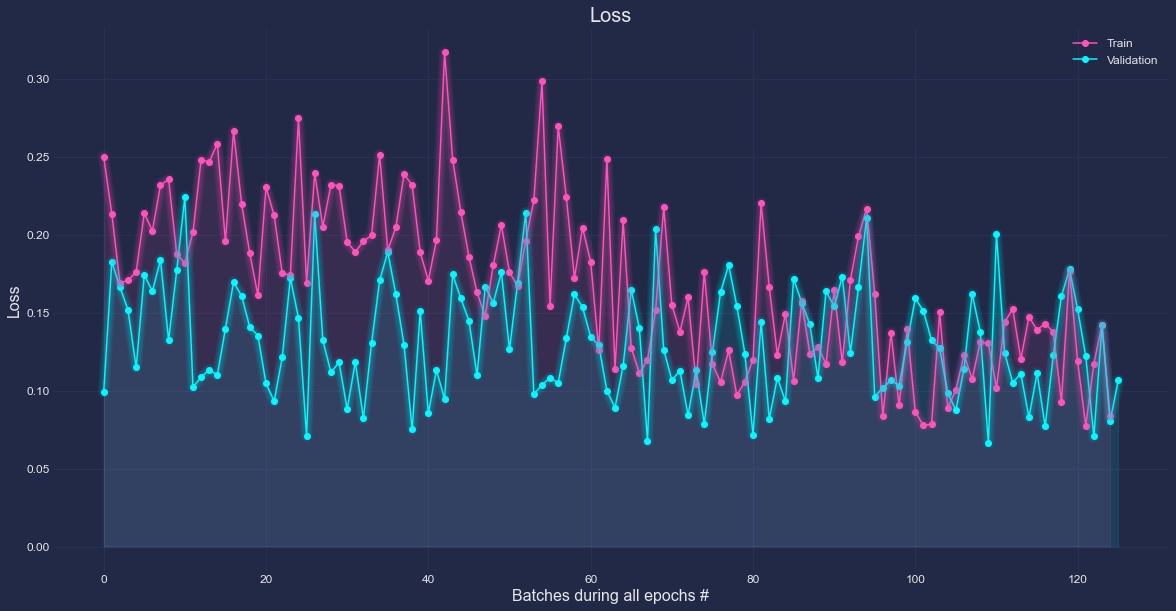

In [78]:
plot_losses(losses=(train_history[:len(train_history)//3], val_history), title="Loss")

## Now let's prepare out test data

In [126]:
from random import randrange

def prepare_test(data: list) -> tuple:
    result = []
    targets = []
    for sequence in data:
        limit = randrange(5, 30)
        
        if len(sequence) - limit > limit:
            miss_index = randrange(limit, len(sequence) - limit) 
        else:
            miss_index = randrange(0, len(sequence))
        targets.append(token_to_id[sequence[miss_index]])
        crop1 = [token_to_id[c] for c in sequence[miss_index-limit:miss_index]]
        # crop2 = [token_to_id[c] for c in sequence[miss_index+limit+1:miss_index+1:-1]]
        result.append(torch.FloatTensor(crop1))
    return (result, targets)

test_data, test_target = prepare_test(genome_test)

## Finally, let's predict(generate) the missing nucleotide

![alt text](https://www.vokrug.tv/pic/product/3/2/c/b/32cb49b46b5988307a2fab35e4a5de1e.jpeg)

In [ ]:
def predict(input_: list, target: list):
    dna_model.eval()
    output, _ = dna_model(input_)
    
    output = nn.utils.rnn.pad_sequence(output, batch_first=True)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)
    
    predicted = torch.argmax(output, dim=1)
    
    return accuracy_score(predicted, targets), f1_score(predicted, targets, average='micro')
        
acc, f1 = predict(test_data, test_target)

print(f"Accuracy: {acc}, f1_score: {f1}")

### The End